In [1]:
using PastaQ
using ITensors
using PyPlot
using Random

In [2]:
#From run_random_circuit.jl
function PastaQ.gate(::GateName"R"; theta::Real, phi::Real)
    [
        cos(theta/2)    (-im * exp(-im * phi) * sin(theta/2))
        (-im * exp(im * phi) * sin(theta/2))     cos(theta/2)
    ]
end

function PastaQ.gate(::GateName"M"; Theta::Real)
    [
        cos(Theta)    0    0    (-im * sin(Theta))
        0    cos(Theta)    (-im * sin(Theta))    0
        0    (-im * sin(Theta))    cos(Theta)    0
        (-im * sin(Theta))    0    0    cos(Theta)
    ]
end

function run(N, depth)
    # Random circuit.
    gates = Vector{Tuple}[]

    for i in 1:depth
        one_qubit_layer = Tuple[]
        two_qubit_layer = Tuple[]

        for j in 1:N
            gate = ("R", j, (theta=2pi*rand(), phi=2pi*rand()))
            push!(one_qubit_layer, gate)
        end

        # Alternate start qubit for pairs.
        idx_first = i % 2 + 1

        for j in idx_first:2:(N-1)
            gate = ("M", (j, j+1), (Theta=2pi*rand(),))
            push!(two_qubit_layer, gate)
        end

        push!(gates, one_qubit_layer)
        push!(gates, two_qubit_layer)
    end

    psi = runcircuit(N, gates)
end

run (generic function with 1 method)

In [3]:
# Since each data matrix compoenets have "Pair"- We just want to get only values.
# Function to extract values from pair

function getValue(P::Pair)
    return P[2]
end

getValue (generic function with 1 method)

In [4]:
# Convert Matrix -> Vector to extract information easily
function BinaryToDecimal(M,N)
    idx = zeros(Int8,size(M)[1],1)
    for i in 1:N
        idx += M[:,i].*2^(i-1)
    end
    
    return idx
end

BinaryToDecimal (generic function with 1 method)

In [5]:
# Generate initial Count dictionary
function Init_Count_Generator(N)
    Count = Dict{Int64,Int64}()
    for i in 0:2^N-1
        push!(Count,i=>0)
    end

    return Count = sort((Count))
end   

Init_Count_Generator (generic function with 1 method)

In [6]:
# Get Probabilities dictionary
function get_probabilities(Count,N)
    Prob = Dict{Int64,Float64}()
    Total_shots = sum(values(Count))
    for i in 0:2^N-1
        push!(Prob,i=>(Count[i]/Total_shots))
    end
    
    return sort(Prob)
end

get_probabilities (generic function with 1 method)

In [7]:
function get_counts(Count,V)
    Keys = keys(Count)
    for k in Keys
        Count[k]+=count(i->(i==k),V)
    end
    return Count
end


get_counts (generic function with 1 method)

In [8]:
# From sampling of state to Decimal representation vector
function execute(ψ,N,shots)
    data = getsamples(ψ, shots ,local_basis=["Z"])
    B = getValue.(data)
    C = BinaryToDecimal(B,N)
    return C
end

execute (generic function with 1 method)

In [9]:
function run_(N, depth,rand_params,Δ)
    # Random circuit.
    rand_idx = 1
    gates = Vector{Tuple}[]
    
    for i in 1:depth
        one_qubit_layer = Tuple[]
        two_qubit_layer = Tuple[]

        for j in 1:N
            gate = ("R", j, (theta=rand_params[rand_idx], phi=rand_params[rand_idx+1]))
            rand_idx+=2
            push!(one_qubit_layer, gate)
        end

        # Alternate start qubit for pairs.
        idx_first = i % 2 + 1

        for j in idx_first:2:(N-1)
            gate = ("M", (j, j+1), (Theta=rand_params[rand_idx]+Δ*(Int(bitrand()[1])*2-1),))
            rand_idx += 1
            push!(two_qubit_layer, gate)
        end

        push!(gates, one_qubit_layer)
        push!(gates, two_qubit_layer)
    end

    psi = runcircuit(N, gates)
end

run_ (generic function with 1 method)

In [10]:
rand_params = rand(Float64,(50000,1))*2pi

50000×1 Matrix{Float64}:
 4.59924363400568
 2.0987236134370066
 3.4822665406503908
 3.4542220147080465
 0.12799811649063114
 1.1915747357012036
 4.8352805757645125
 5.416665781167976
 1.4948570310985096
 5.12635769697793
 2.083520856906745
 4.400227707577522
 5.954347489929608
 ⋮
 1.7698171739268715
 0.9309843596507433
 0.8591489232138216
 0.3050255272843757
 0.6562145540787517
 0.10038848079987164
 4.9314062672205115
 0.5665800399351153
 3.4205469804492723
 2.576492171525936
 4.630501431277251
 3.5481586850698714

In [11]:
# XEF is function for Cross Entropy Benchmarking Fidelity.
function e_u(Prob_0)
    e_u = 0
    for i in 0:2^N-1
        e_u +=Prob_0[i]^2
    end
    
    return e_u
end

function m_u(Prob_0,Prob)
    m_u = 0
    for i in 0:2^N-1
        m_u += Prob_0[i]*Prob[i]
    end
    
    return m_u
end

function XEF(Prob_0,Prob)
    E_u = e_u(Prob_0)
    M_u = m_u(Prob_0, Prob)
    U_u = 1/(2^N)
    f = (M_u-U_u)/(E_u - U_u)
    return f
end

XEF (generic function with 1 method)

In [36]:
Δ_ = Vector{Float64}()
N = 4 # The number of Qubit
D_ = Vector{Int64}([1,5,10,20,50]) # Depths of Circuit
shots = 1024 # The number of shot
XEF_ = Vector{Float64}()



for i in 0:100
    push!(Δ_,i*0.01)
end

for D in D_ 
    Prob_0 = Dict{Int64,Float64}()
    Prob = Dict{Int64,Float64}()
    j = 0
    for Δ in Δ_
        println("Δ : ",Δ)
        Count = Init_Count_Generator(N) # Dictionary for counting result
        for i in 1:shots
            if i%100 == 0
                println(i)
            end
            ϕ = run_(N,D,rand_params,Δ) # Get state
            shot_result = execute(ϕ,N,1) # Get decimal representation of shot result(Vector)
            Count = get_counts(Count,shot_result) # Get Counts from shot_result
        end

        if j == 0
            println("First")
            Prob_0 = get_probabilities(Count,N) # Get probabilities from Count
            xef = XEF(Prob_0,Prob_0)
            push!(XEF_,xef)
            j+=1
        else 
            Prob = get_probabilities(Count,N)
            xef = XEF(Prob_0,Prob)
            push!(XEF_,xef)
        end
    end
end

Δ : 0.0
100
200
300
400
500
600
700
800
900
1000
First
Δ : 0.01
100
200
300
400
500
600
700
800
900
1000
Δ : 0.02
100
200
300
400
500
600
700
800
900
1000
Δ : 0.03
100
200
300
400
500
600
700
800
900
1000
Δ : 0.04
100
200
300
400
500
600
700
800
900
1000
Δ : 0.05
100
200
300
400
500
600
700
800
900
1000
Δ : 0.06
100
200
300
400
500
600
700
800
900
1000
Δ : 0.07
100
200
300
400
500
600
700
800
900
1000
Δ : 0.08
100
200
300
400
500
600
700
800
900
1000
Δ : 0.09
100
200
300
400
500
600
700
800
900
1000
Δ : 0.1
100
200
300
400
500
600
700
800
900
1000
Δ : 0.11
100
200
300
400
500
600
700
800
900
1000
Δ : 0.12
100
200
300
400
500
600
700
800
900
1000
Δ : 0.13
100
200
300
400
500
600
700
800
900
1000
Δ : 0.14
100
200
300
400
500
600
700
800
900
1000
Δ : 0.15
100
200
300
400
500
600
700
800
900
1000
Δ : 0.16
100
200
300
400
500
600
700
800
900
1000
Δ : 0.17
100
200
300
400
500
600
700
800
900
1000
Δ : 0.18
100
200
300
400
500
600
700
800
900
1000
Δ : 0.19
100
200
300
400
500
600
700
800
900
1

1000
Δ : 0.59
100
200
300
400
500
600
700
800
900
1000
Δ : 0.6
100
200
300
400
500
600
700
800
900
1000
Δ : 0.61
100
200
300
400
500
600
700
800
900
1000
Δ : 0.62
100
200
300
400
500
600
700
800
900
1000
Δ : 0.63
100
200
300
400
500
600
700
800
900
1000
Δ : 0.64
100
200
300
400
500
600
700
800
900
1000
Δ : 0.65
100
200
300
400
500
600
700
800
900
1000
Δ : 0.66
100
200
300
400
500
600
700
800
900
1000
Δ : 0.67
100
200
300
400
500
600
700
800
900
1000
Δ : 0.68
100
200
300
400
500
600
700
800
900
1000
Δ : 0.6900000000000001
100
200
300
400
500
600
700
800
900
1000
Δ : 0.7000000000000001
100
200
300
400
500
600
700
800
900
1000
Δ : 0.71
100
200
300
400
500
600
700
800
900
1000
Δ : 0.72
100
200
300
400
500
600
700
800
900
1000
Δ : 0.73
100
200
300
400
500
600
700
800
900
1000
Δ : 0.74
100
200
300
400
500
600
700
800
900
1000
Δ : 0.75
100
200
300
400
500
600
700
800
900
1000
Δ : 0.76
100
200
300
400
500
600
700
800
900
1000
Δ : 0.77
100
200
300
400
500
600
700
800
900
1000
Δ : 0.78
100
200
3

300
400
500
600
700
800
900
1000
Δ : 0.17
100
200
300
400
500
600
700
800
900
1000
Δ : 0.18
100
200
300
400
500
600
700
800
900
1000
Δ : 0.19
100
200
300
400
500
600
700
800
900
1000
Δ : 0.2
100
200
300
400
500
600
700
800
900
1000
Δ : 0.21
100
200
300
400
500
600
700
800
900
1000
Δ : 0.22
100
200
300
400
500
600
700
800
900
1000
Δ : 0.23
100
200
300
400
500
600
700
800
900
1000
Δ : 0.24
100
200
300
400
500
600
700
800
900
1000
Δ : 0.25
100
200
300
400
500
600
700
800
900
1000
Δ : 0.26
100
200
300
400
500
600
700
800
900
1000
Δ : 0.27
100
200
300
400
500
600
700
800
900
1000
Δ : 0.28
100
200
300
400
500
600
700
800
900
1000
Δ : 0.29
100
200
300
400
500
600
700
800
900
1000
Δ : 0.3
100
200
300
400
500
600
700
800
900
1000
Δ : 0.31
100
200
300
400
500
600
700
800
900
1000
Δ : 0.32
100
200
300
400
500
600
700
800
900
1000
Δ : 0.33
100
200
300
400
500
600
700
800
900
1000
Δ : 0.34
100
200
300
400
500
600
700
800
900
1000
Δ : 0.35000000000000003
100
200
300
400
500
600
700
800
900
1000
Δ : 

900
1000
Δ : 0.75
100
200
300
400
500
600
700
800
900
1000
Δ : 0.76
100
200
300
400
500
600
700
800
900
1000
Δ : 0.77
100
200
300
400
500
600
700
800
900
1000
Δ : 0.78
100
200
300
400
500
600
700
800
900
1000
Δ : 0.79
100
200
300
400
500
600
700
800
900
1000
Δ : 0.8
100
200
300
400
500
600
700
800
900
1000
Δ : 0.81
100
200
300
400
500
600
700
800
900
1000
Δ : 0.8200000000000001
100
200
300
400
500
600
700
800
900
1000
Δ : 0.8300000000000001
100
200
300
400
500
600
700
800
900
1000
Δ : 0.84
100
200
300
400
500
600
700
800
900
1000
Δ : 0.85
100
200
300
400
500
600
700
800
900
1000
Δ : 0.86
100
200
300
400
500
600
700
800
900
1000
Δ : 0.87
100
200
300
400
500
600
700
800
900
1000
Δ : 0.88
100
200
300
400
500
600
700
800
900
1000
Δ : 0.89
100
200
300
400
500
600
700
800
900
1000
Δ : 0.9
100
200
300
400
500
600
700
800
900
1000
Δ : 0.91
100
200
300
400
500
600
700
800
900
1000
Δ : 0.92
100
200
300
400
500
600
700
800
900
1000
Δ : 0.93
100
200
300
400
500
600
700
800
900
1000
Δ : 0.940000000

In [39]:
XEF_ = reshape(XEF_,(505,1))
@show XEF_

XEF_ = [1.0; 1.0101121137544435; 0.9971944216570959; 1.0152365326770576; 1.009001914137271; 0.9984030626196336; 1.0157670221493027; 1.011096527208094; 0.9814219305441619; 0.9845665846322122; 0.9896363139185125; 0.9624883784522833; 0.9976045939294503; 0.9710090237899918; 0.9602023516543615; 0.9595351380913317; 0.9724364232977851; 0.9701066447908121; 0.9608476893628657; 0.9675854525567404; 0.9462400875034181; 0.9304183757178015; 0.9342138364779874; 0.919775772491113; 0.9051736395952967; 0.9334974022422751; 0.9225485370522286; 0.9080448455017774; 0.876133442712606; 0.8934372436423298; 0.895701394585726; 0.8840032813781789; 0.8324747060432048; 0.8642329778506973; 0.8271479354662291; 0.8280831282471972; 0.8047634673229423; 0.8132567678424939; 0.8105879135903746; 0.8007219031993438; 0.8204757998359311; 0.758561662564944; 0.7571834837298332; 0.7406343997812415; 0.7394312277823353; 0.7452173913043478; 0.7353677878042111; 0.7372491112934099; 0.7213781788351108; 0.6788679245283019; 0.69658736669

505×1 Matrix{Float64}:
  1.0
  1.0101121137544435
  0.9971944216570959
  1.0152365326770576
  1.009001914137271
  0.9984030626196336
  1.0157670221493027
  1.011096527208094
  0.9814219305441619
  0.9845665846322122
  0.9896363139185125
  0.9624883784522833
  0.9976045939294503
  ⋮
 -0.07046001312240285
  0.012010643726762412
 -0.03745352482321207
 -0.015929139024568054
 -0.04552744769264416
 -0.0066341036669825765
  0.050448348764307066
  0.03739884814463804
  0.0024969016548808047
 -0.008675366333746446
 -0.001385142523875483
  0.0022599693810599984

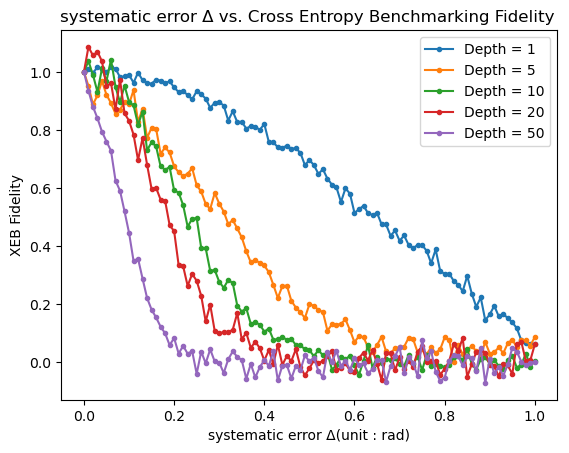

PyObject <matplotlib.legend.Legend object at 0x00000000018801F0>

In [46]:
title("systematic error Δ vs. Cross Entropy Benchmarking Fidelity ")
plt.xlabel("systematic error Δ(unit : rad)")
plt.ylabel("XEB Fidelity")

for i in 0:4
    plot(Δ_,XEF_[i*101+1:(i+1)*101,1],marker=".",label="Depth = "*string(D_[i+1]))
end

legend()